# Flow example

Consider the following opitmization problem: Given the a pipe network in your factory, what is the maximum flow you can get out of it? This is one of the most common graph problems, and it's called the "[max-flow](https://en.wikipedia.org/wiki/Maximum_flow_problem)" problem. From a mathematical perspective, this looks as follows:
\begin{equation}
\begin{array}{ll}
\text{minimize} & \text{Flow} \\
\text{subject to} & \text{Conversation of mass} \\
& \text{Capacity constraints} \\
& \text{Physical onstraints}
\end{array}
\end{equation}

As we did with the supply chain example, we first have to setup the problem, then define the variables, constraints and objective function and finally solve the problem.

## Getting started
Ok, now that we have narrowed down what we want solve, let's setup the problem and get the data into Python:
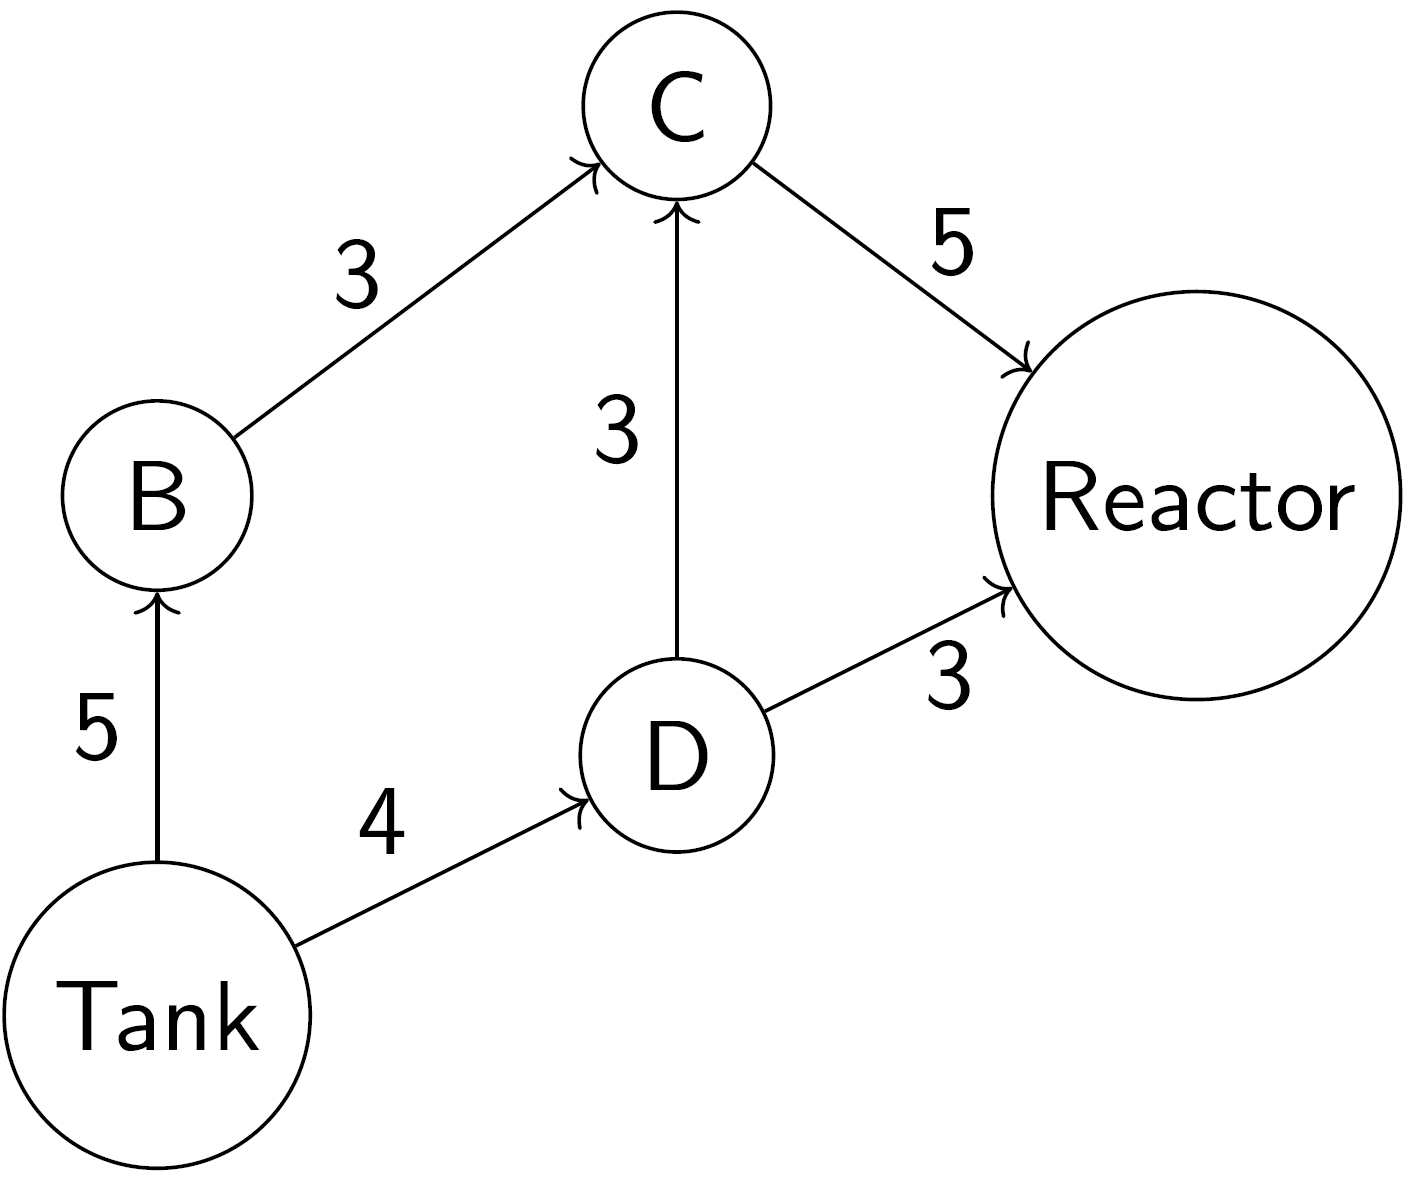

In [2]:
import xpress as xp
%env XPRESS=..
from dataclasses import dataclass
import networkx as nx
import matplotlib.pyplot as plt

model = xp.problem("Flow example")
        
# We need to set frozen to true so that it becomes immutable and therefore hashable
@dataclass(frozen = True)
class Edge:
    origin: str
    destination: str      
    max_capacity: float
        
# Define the data
edges = [Edge("Tank", "B", 5),
         Edge("Tank", "D", 4),
         Edge("B", "C", 3),
         Edge("D", "C", 3),
         Edge("D", "Reactor", 3),
         Edge("C", "Reactor", 5)]

# Define the tank and reactor
nodes = []
for edge in edges:
    nodes.append(edge.origin)
    nodes.append(edge.destination)
nodes = set(nodes)
tank = "Tank"
reactor = "Reactor"

So how does our network look like? Well, let's have a look:

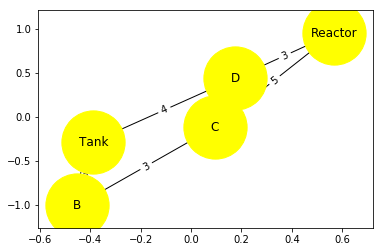

In [3]:
def plot_network(edges, solution):
    """Plotting the flow network"""
    # Define what is plotted along the edges
    if (solution is None):
        values = {(edge.origin, edge.destination) : f'{edge.max_capacity}' for edge in edges}
    else:
        values = {(edge.origin, edge.destination) : 
                                                    f'{model.getSolution(flows[edge])}/{edge.max_capacity}' for edge in edges}
        
    # Instantiate the graph and add the edges
    g = nx.DiGraph()
    g.add_edges_from([(edge.origin, edge.destination) for edge in edges])
    pos = nx.spring_layout(g)
    nx.draw_networkx_nodes(g, pos, cmap=plt.get_cmap('jet'), node_size = 4000, node_color = "yellow")
    nx.draw_networkx_edges(g, pos, arrows = True)    
    nx.draw_networkx_edge_labels(g, pos, edge_labels = values)
    nx.draw_networkx_labels(g, pos);
    
plot_network(edges, None)

## The variables
We are interested in the flows through this network. Therefore we define the flow variables for each arrow $f_{o,d}$, where $o$ and $d$ are the origin and destination. In addition, we set the bounds of the variables: the lower bound is $0$ (the flow as to be non-negative) and the upper bound is the maximum capacity on the given edge (this is in fact the capacity constraint). How does that look like in code?

In [4]:
flows = {edge : xp.var(vartype = xp.continuous, lb = 0, ub = edge.max_capacity, 
                   name=f'f_({edge.origin},{edge.destination})') for edge in edges}
model.addVariable(flows)

## Conservation of mass
What flows out must flow in, except for at the tank and reactor level, i.e. $\sum \limits_{j} f_{i,j} - \sum \limits_{k} f_{k,i} = 0, \forall i \backslash \{Tank,Reactor\}$. How does that look like in code?

In [5]:
flow_balance = [xp.Sum(flows[edge] for edge in edges if edge.origin == node) 
               == xp.Sum(flows[edge] for edge in edges if edge.destination == node)
               for node in nodes if node != tank and node != reactor]
model.addConstraint(flow_balance)

## Objective function
Next, we look at the objective function. In our case, we would like to maximize the flow from the Tank to the Reactor. This is equivalent to saying that we want to maximize the flow of all the edges that end up at the reactor, because it is the only way to get there, i.e. we want to maximize $\sum \limits_i f_{i,\text{Reactor}}$. How does that look like in code?

In [6]:
model.setObjective(xp.Sum(flows[edge] for edge in edges if edge.destination == reactor), sense = xp.maximize)

## Solving the model
At this point we have the problem formulation at hand and can solve it:

In [7]:
model.solve()
print(f'Problem status: {model.getProbStatusString()}')

Problem status: lp_optimal


## Inspecting the solution
To understand what the solution yields us, let's print out the values and have a look.

The maximum flow to the reactor is 7.0
Tank -> B: 3.0
Tank -> D: 4.0
B -> C: 3.0
D -> C: 1.0
D -> Reactor: 3.0
C -> Reactor: 4.0


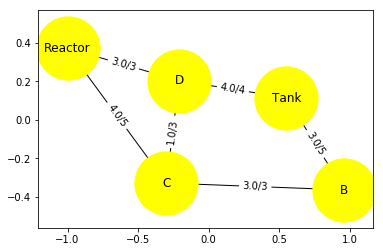

In [8]:
print(f'The maximum flow to the reactor is {model.getObjVal()}')
for edge in edges:
    print(f'{edge.origin} -> {edge.destination}: {model.getSolution(flows[edge])}')
    
solution = {edge : model.getSolution(flows[edge]) for edge in edges}
plot_network(edges, solution)

Observations from the picture:
    - The connection "Tank --> D" is the overall bottleneck of the system
    - Considering the connections to the reactor, we still could transport another unit to the reactor from C, if we could get the material in.
    - The "Tank --> B" pipe is particularly oversized for this flow, and will not ever carry 60% of its total capacity.

In [10]:
a = xp.var(vartype = xp.continuous, 
           lb = 0, ub =1, name = 'a')

In [12]:
a.lb = 5

In [20]:
edge = edges[0]
flows[edge]

f_(Tank,B)

In [22]:
import numpy as np

x = np.random.rand(100,1)
y = 

In [25]:
coord[50,1]

0.2468966007173281